In [2]:
import os
import sys

sys.path.append('packages')

from ued_solid_state_FY19_utilities import *
from gas_phase_UED_cython_functions import *

from scipy.optimize import curve_fit

from tqdm import tqdm

import pandas as pd
import numpy as np
#import dask.dataframe as df
#from dask import delayed
import cv2

# Cython utilities
import os
import sys


import numpy as np
import matplotlib.pyplot as plt
import matplotlib
#%matplotlib widget
import glob

In [3]:
import pandas as pd

## Input parameters

In [4]:
# Time scan folder path
# path_df = '/cds/group/ued/data/ueduu7703/SampleScreen/20210814/Run/20210814_1445/'
# path_df = '/sdf/data/lcls/ds/ued_testfac/scratch/jupyter_notebook_UED_solid_sample_codes/poly_crystal_demo_data/scan001/'
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20230918/Run/20230918_1254/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20230918/Run/20230918_1249/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20230918/Run/20230918_1310/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20230918/Run/20230918_1315/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20230918/Run/20230918_1320/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20230918/Run/20230918_1324/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20230918/Run/20230918_1328/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20230918/Run/20230918_1332/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20231016/Run/20231016_1135/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20231016/Run/20231016_1144/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20231016/Run/20231016_1203/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20231030/Run/20231030_1246/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20231030/Run/20231030_1541/'; # data for the Bi scan 10/30, Temporal resolution
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/guedr4comm/nosample/20231030/Run/20231030_1612/'; # data for the Bi scan 10/30, Temporal resolution
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/ueduu101/Cyclopentadiene/20231103/Run/20231103_1141/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/ueduu101/Cyclopentadiene/20231103/Run/20231103_2319/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/ueduu101/Cyclopentadiene/20231103/Run/20231103_2329/';
# path_df = '/sdf/data/lcls/ds/ued_testfac/data/ueduu101/Cyclopentadiene/20231103/Run/20231103_2335/';
path_df = '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/T-zero/20180823_0253/';


# Image dimensions
num_row = 1024
num_col = 1024

# For azimuthal average
r_max = 500 # maximum radius to perform azimuthal average (in pixel)
s_cal = 0.02155 # s calibration (A-1 per pixel)
# s_cal = 0.0213 # s calibration (A-1 per pixel)
pre_t0_point_num = 4 # number of time points before time zero, use for difference pattern calculation

## Read in data

In [11]:
# Get the file lists
#file_list_df = get_diffraction_file_list(path_df, keyword='ANDOR1*tif')
#file_list_df = glob.glob(os.path.join('/sdf/data/lcls/ds/ued_testfac/data/ueduu101/TMCP/20231108/Run/20231108_1919/images-ANDOR1','*'))
dataPath = '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/T-zero/20180823_0253/'
#dataPath = '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180623/Run/20180623_2349'
runPath = "/*/*/ANDOR1_*.tif"
newPath = dataPath + runPath

file_list_df = glob.glob(newPath) 
print(len(file_list_df))
files = []
for i in range(60):
    for f in range(len(file_list_df)):
        base, name = os.path.split(file_list_df[f])
        name = name.split('_')
        name = name[1]
        name = name.split('-')
        if i==int(name[1]):
            files.append(file_list_df[f])
            break
print(len(files))
# Assign shared memory for multip
#file_list_df = file_list_df[30:]#loading different images
file_list_df = files[:]#files[int(len(files)/2):]#files[:int(len(files)/2)]
num_image_df = len(file_list_df)

print('Number of diffraction images: %d'%(num_image_df))

# Remove subscript df in variables for diffraction patterns for simplicity
scan_num = assign_shared_memory((num_image_df,))
delay =  assign_shared_memory((num_image_df,))

img_set = assign_shared_memory((num_image_df, num_row, num_col))

# Read diffraction data
read_diffraction_data_sharedarray(file_list_df, img_set, scan_num, delay)
camera_bg= preprocess_gas_diffraction_data(img_set, hot_pixel_thres=50000)

img_mean = cal_nanmean_image_axis_0(img_set)


62
9
Number of diffraction images: 9


IndexError: list index out of range

In [89]:
f

215

/tmp/ipykernel_207249/3610773602.py:20: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(img_mean)*mask_hole)
/tmp/ipykernel_207249/3610773602.py:20: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(img_mean)*mask_hole)


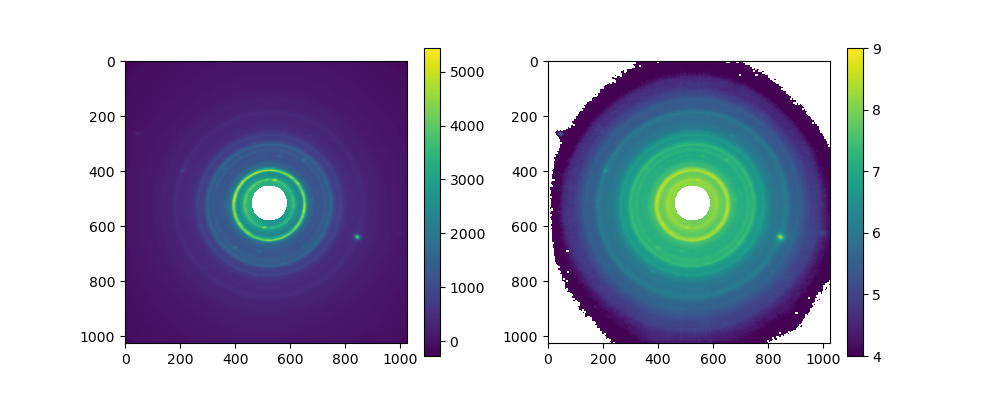

In [36]:

# cm_x = 503
# cm_y = 499

cm_x = 524
cm_y = 515

# cm_x = 480
# cm_y = 499

# cm = 1-gen_circular_mask(cm_x, cm_y, 187, num_col, num_row)
mask_hole =  1-gen_circular_mask(cm_x, cm_y, 60, 1024, 1024)
mask_hole[mask_hole<1] = np.nan

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow((img_mean)*mask_hole)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(np.log(img_mean)*mask_hole)
plt.colorbar()
plt.clim([4, 9])

## Determination of centroid

In [37]:
# low and high threshold to find ring centroid
threshold_low = 250
threshold_high = 1500
# threshold_low  = 1000
# threshold_high = 3200

center_diffraction = cal_one_diffraction_pattern_center_double_threshold(img_mean*mask_hole, threshold_low, threshold_high, flagPlot=12)
mask_diffraction = gen_circular_mask(center_diffraction[0], center_diffraction[1], 80, num_row, num_col)
mask_diffraction = (1 - mask_diffraction)*gen_circular_mask(center_diffraction[0], center_diffraction[1], 500, num_row, num_col)
print(center_diffraction)

# Uncomment this line if manual centroid input is needed
# center_diffraction = [504, 507]


[524.61333898 534.31107477]


## Azimuthal average

In [38]:
s = np.arange(r_max) * s_cal # total s range

inten_mean_set = np.zeros((num_image_df, ))
rad_pro_set = np.zeros((r_max, num_image_df))
for ind in tqdm(range(num_image_df)):
    rad_pro_set[:,ind] = azimuthal_average_cython(center_diffraction, img_set[ind,:,:]*mask_hole, r_max)
    inten_mean_set[ind] = rad_pro_set[int(1.5/s_cal):int(8/s_cal), ind].mean(axis=0)
    rad_pro_set[:,ind] = rad_pro_set[:,ind] / inten_mean_set[ind]

100%|██████████| 175/175 [00:06<00:00, 25.17it/s]


## Plot some results 

/tmp/ipykernel_207249/3550583238.py:16: RuntimeWarning: invalid value encountered in divide
  rad_pro_avg_diff[:,i] = ( rad_pro_avg[:,i] - rad_pro_avg_pre_t0 ) / rad_pro_avg_pre_t0 * 100
/tmp/ipykernel_207249/3550583238.py:17: RuntimeWarning: invalid value encountered in divide
  rad_pro_std_diff[:,i] = rad_pro_std[:,i] / rad_pro_avg_pre_t0 * 100


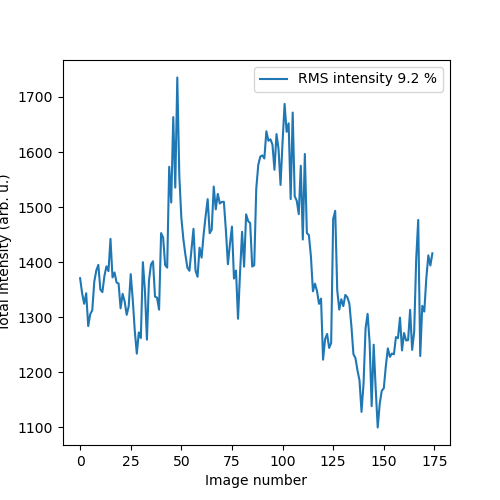

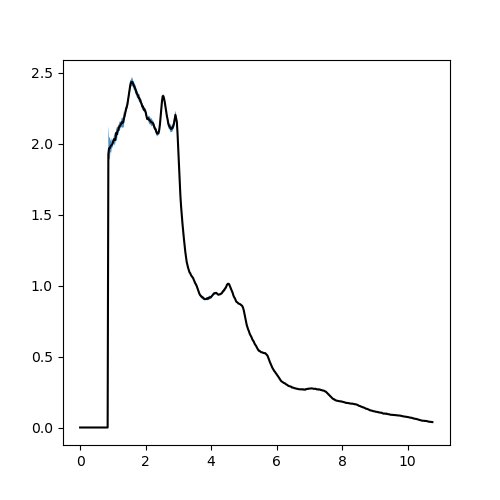

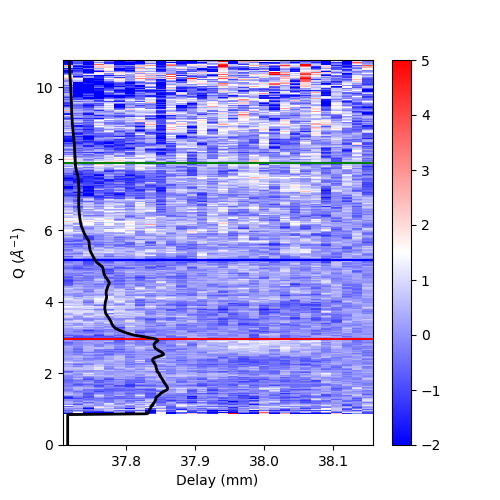

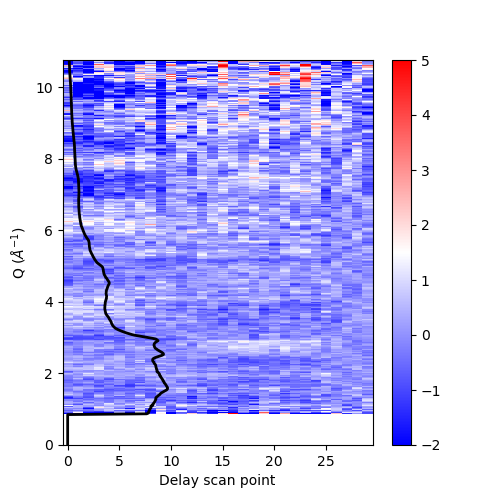

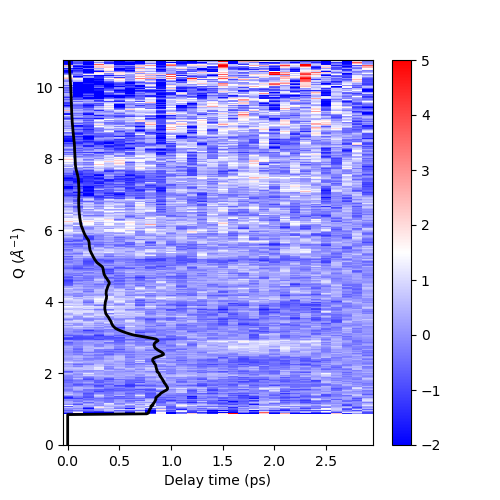

In [39]:
delay_unique = np.unique(delay)
rad_pro_avg = np.zeros((r_max, len(delay_unique)))
rad_pro_std = np.zeros((r_max, len(delay_unique)))

for (ind_de, de) in enumerate(delay_unique):
    ind = np.where(delay==de)
    rad_pro_avg[:,ind_de] = rad_pro_set[:,ind[0]].mean(axis=1)
    rad_pro_std[:,ind_de] = rad_pro_set[:,ind[0]].std(axis=1)
        
rad_pro_avg_pre_t0 = rad_pro_avg[:,-pre_t0_point_num:].mean(axis=1)

rad_pro_avg_diff = np.zeros_like(rad_pro_avg)
rad_pro_std_diff = np.zeros_like(rad_pro_avg)

for i in np.arange(rad_pro_avg.shape[1]):
    rad_pro_avg_diff[:,i] = ( rad_pro_avg[:,i] - rad_pro_avg_pre_t0 ) / rad_pro_avg_pre_t0 * 100
    rad_pro_std_diff[:,i] = rad_pro_std[:,i] / rad_pro_avg_pre_t0 * 100
        
s1 = 2.95
s2 = 5.17
s3 = 7.88

plt.figure(figsize=(5,5))
plt.plot(inten_mean_set, label=r'RMS intensity %2.1f %%'%(np.std(inten_mean_set)/np.mean(inten_mean_set)*100))
plt.xlabel('Image number')
plt.legend()
plt.ylabel('Total intensity (arb. u.)')

plt.figure(figsize=(5,5))
plt.plot(s, rad_pro_avg[:,0], 'k-')
plt.fill_between(s, rad_pro_avg[:,0]-rad_pro_std[:,0], rad_pro_avg[:,0]+rad_pro_std[:,0], alpha=0.8)

plt.figure(figsize=(5,5))
plt.pcolormesh(delay_unique, s, rad_pro_avg_diff, vmin=-2, vmax=5, cmap='bwr')
plt.axhline(y=s1,color='r');
plt.axhline(y=s2,color='b');
plt.axhline(y=s3,color='g');
plt.colorbar() 
plt.xlabel('Delay (mm)')
plt.ylabel(r'Q ($\AA^{-1}$)')
plt.plot(rad_pro_avg[:,0]/rad_pro_avg[:,0].max()*(delay_unique.max()-delay_unique.min())/3+delay_unique.min(), s, 'k-', linewidth=2)

delay_points = np.arange(len(delay_unique))

plt.figure(figsize=(5,5))
plt.pcolormesh(delay_points, s, rad_pro_avg_diff, vmin=-2, vmax=5, cmap='bwr')
plt.colorbar() 
plt.xlabel('Delay scan point')
plt.ylabel(r'Q ($\AA^{-1}$)')
plt.plot(rad_pro_avg[:,0]/rad_pro_avg[:,0].max()*delay_points.max()/3, s, 'k-', linewidth=2)

delay_time = ( delay_unique - delay_unique[0] ) / 0.15

plt.figure(figsize=(5,5))
plt.pcolormesh(delay_time, s, rad_pro_avg_diff, vmin=-2, vmax=5, cmap='bwr')
plt.colorbar() 
plt.xlabel('Delay time (ps)')
plt.ylabel(r'Q ($\AA^{-1}$)')
plt.plot(rad_pro_avg[:,0]/rad_pro_avg[:,0].max()*delay_time.max()/3, s, 'k-', linewidth=2)


[37.7151 37.7301 37.7451 37.7601 37.7751 37.7901 37.8051 37.8201 37.8351
 37.8501 37.865  37.88   37.895  37.91   37.925  37.94   37.955  37.97
 37.985  37.9999 38.0149 38.0299 38.0449 38.0599 38.0749 38.0899 38.1049
 38.1199 38.1349 38.1498]


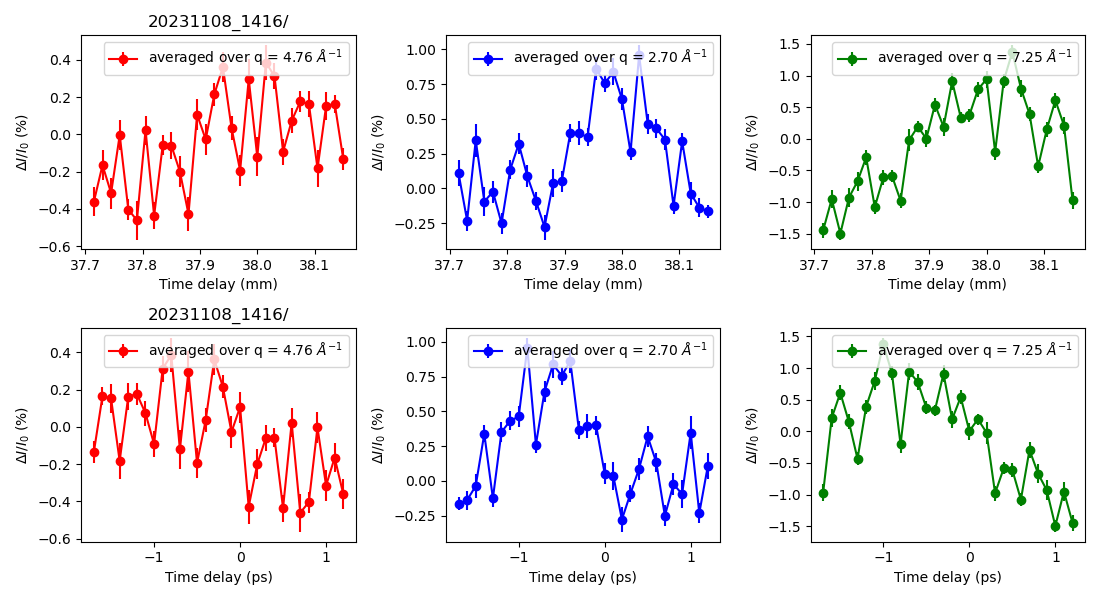

In [40]:
# s1 = 7.5
# s2 = 4.98
# s3 = 5.76

s1 = 4.76 #3
# s2 = 5.11
s2 = 2.7 #5.18
s3 = 7.25 #7.80

r1 = int(s1 / s_cal)
r2 = int(s2 / s_cal)
r3 = int(s3 / s_cal)

r_half_width = 5

inten_avg_1 = np.mean(rad_pro_avg_diff[r1-r_half_width:r1+r_half_width,:], axis=0)
inten_std_1 = np.sqrt(np.mean(rad_pro_std_diff[r1-r_half_width:r1+r_half_width,:]**2, axis=0))/rad_pro_std_diff[r1-r_half_width:r1+r_half_width,:].shape[0]

inten_avg_2 = np.mean(rad_pro_avg_diff[r2-r_half_width:r2+r_half_width,:], axis=0)
inten_std_2 = np.sqrt(np.mean(rad_pro_std_diff[r2-r_half_width:r2+r_half_width,:]**2, axis=0))/rad_pro_std_diff[r2-r_half_width:r2+r_half_width,:].shape[0]

inten_avg_3 = np.mean(rad_pro_avg_diff[r3-r_half_width:r3+r_half_width,:], axis=0)
inten_std_3 = np.sqrt(np.mean(rad_pro_std_diff[r3-r_half_width:r3+r_half_width,:]**2, axis=0))/rad_pro_std_diff[r3-r_half_width:r3+r_half_width,:].shape[0]

plt.figure(figsize=(11, 6))

plt.subplot(2,3,1)
plt.errorbar(delay_unique, inten_avg_1, inten_std_1,color='r', fmt='-o', label=r'averaged over q = %1.2f $\AA^{-1}$'%s1)
plt.ylabel(r'$\Delta I/I_0$ (%)')
plt.xlabel('Time delay (mm)')
plt.title(path_df[-14:])
plt.legend()

plt.subplot(2,3,2)
plt.errorbar(delay_unique, inten_avg_2, inten_std_2, color='b', fmt='-o', label=r'averaged over q = %1.2f $\AA^{-1}$'%s2)
plt.xlabel('Time delay (mm)')
plt.ylabel(r'$\Delta I/I_0$ (%)')
plt.legend()

plt.subplot(2,3,3)
plt.errorbar(delay_unique, inten_avg_3, inten_std_3, color='g', fmt='-o', label=r'averaged over q = %1.2f $\AA^{-1}$'%s3)
plt.xlabel('Time delay (mm)')
plt.ylabel(r'$\Delta I/I_0$ (%)')
plt.legend()

# plt.tight_layout()
# plt.show()

T0 = 37.895 #mm
Time_real = -(delay_unique-T0)/0.15 # ps
print(delay_unique)
# plt.figure(figsize=(11, 3))
plt.subplot(2,3,4)
plt.errorbar(Time_real, inten_avg_1, inten_std_1,color='r', fmt='-o', label=r'averaged over q = %1.2f $\AA^{-1}$'%s1)
plt.ylabel(r'$\Delta I/I_0$ (%)')
plt.xlabel('Time delay (ps)')
plt.title(path_df[-14:])
plt.legend()

plt.subplot(2,3,5)
plt.errorbar(Time_real, inten_avg_2, inten_std_2, color='b', fmt='-o', label=r'averaged over q = %1.2f $\AA^{-1}$'%s2)
plt.xlabel('Time delay (ps)')
plt.ylabel(r'$\Delta I/I_0$ (%)')
plt.legend()

plt.subplot(2,3,6)
plt.errorbar(Time_real, inten_avg_3, inten_std_3, color='g', fmt='-o', label=r'averaged over q = %1.2f $\AA^{-1}$'%s3)
plt.xlabel('Time delay (ps)')
plt.ylabel(r'$\Delta I/I_0$ (%)')
plt.legend()

plt.tight_layout()
plt.show()

# fitting with an error function


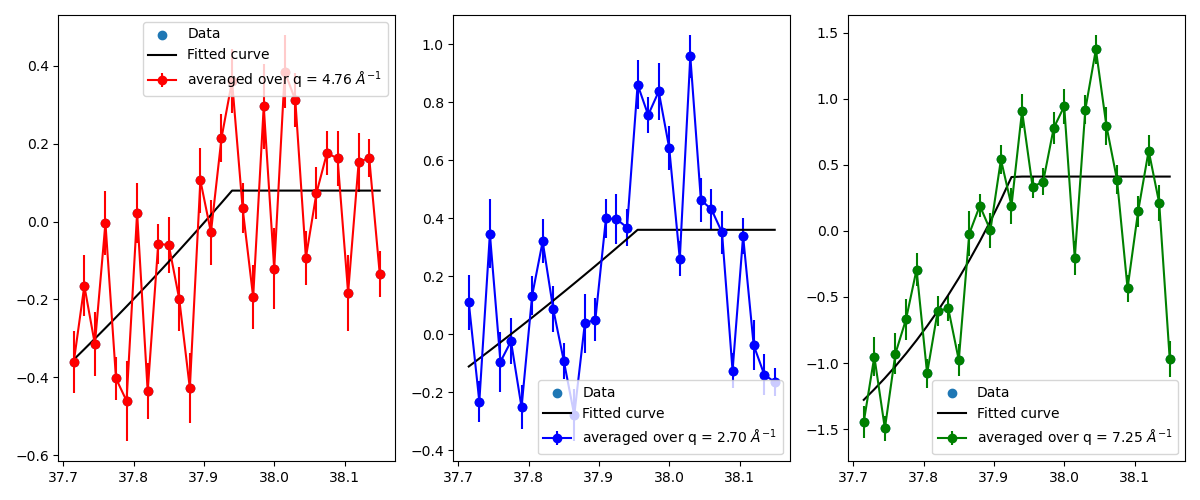

[-1.61765412  1.33131769  1.12348149  0.41704745]
[ 0.07970613  2.72927244  8.65132148 -0.30000005]
[ 0.36082951  3.48259375 11.00078566 -0.40000036]
[ 0.41219563  3.00802974  1.69638393 -0.20202134]
fit1:  37.94000000804839
fit2:  37.955000054138715
fit3:  37.92530320127875
mean:  37.94010108782195


In [41]:
# Generate sample data

# Define the error function
def error_function(x, a, b, c, d):
    return a * np.exp(-b * (x - c) ** 2) + d

def t0_finder(x, a, b, tau, p0):
    """
    Exponential function for fitting data.

    """
    y = np.piecewise(x, [x < p0, x >= p0], [lambda x: a, lambda x: a + b*(np.exp(-(x-p0)/tau) - 1)])
    return y
    
def expo_fitting(x, y, bounds, func=t0_finder):
    popt, pcov = curve_fit(func, x, y, bounds=bounds)
    error = np.sqrt(np.diag(pcov))
    return func(x, *popt), popt, error

# x_data = np.linspace(-2, 2, 100)
# y_data = 3 * np.exp(-2 * x_data ** 2) + 0.5

# Add some noise to the data
# np.random.seed(0)
# y_data += 0.2 * np.random.normal(size=len(x_data))

# Fit the data to the error function
params, covariance = curve_fit(error_function, Time_real, inten_avg_3)

bounds = ([-1, -20, 0.1, -1], [1, 20, 20, 1])
fit3, popt3, error3 = expo_fitting(Time_real, inten_avg_3, bounds=bounds, func=t0_finder)
fit2, popt2, error2 = expo_fitting(Time_real, inten_avg_2, bounds=bounds, func=t0_finder)
fit1, popt1, error1 = expo_fitting(Time_real, inten_avg_1, bounds=bounds, func=t0_finder)

# Generate points for the fitted curve
# x_fit = np.linspace(-2, 2, 100)
y_fit = error_function(Time_real, *params)

# Plot the original data and the fitted curve
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12,5))

ax1.errorbar(delay_unique, inten_avg_1, inten_std_1, color='r', fmt='-o', label=r'averaged over q = %1.2f $\AA^{-1}$'%s1)
ax1.scatter(delay_unique, inten_avg_1, label='Data')
#plt.plot(Time_real, y_fit, label='Fitted curve', color='r')
ax1.plot(delay_unique, fit1, label='Fitted curve', color='black')             
ax1.legend()

ax2.errorbar(delay_unique, inten_avg_2, inten_std_2, color='b', fmt='-o', label=r'averaged over q = %1.2f $\AA^{-1}$'%s2)
ax2.scatter(delay_unique, inten_avg_2, label='Data')
#plt.plot(Time_real, y_fit, label='Fitted curve', color='r')
ax2.plot(delay_unique, fit2, label='Fitted curve', color='black')             
ax2.legend()


ax3.errorbar(delay_unique, inten_avg_3, inten_std_3, color='g', fmt='-o', label=r'averaged over q = %1.2f $\AA^{-1}$'%s3)
ax3.scatter(delay_unique, inten_avg_3, label='Data')
#plt.plot(Time_real, y_fit, label='Fitted curve', color='r')
ax3.plot(delay_unique, fit3, label='Fitted curve', color='black')             
ax3.legend()

plt.tight_layout()
plt.show()

print(params)
print(popt1)
print(popt2)
print(popt3)
print('fit1: ',T0-(popt1[3]*0.15))# ps
print('fit2: ',T0-(popt2[3]*0.15))# ps
print('fit3: ',T0-(popt3[3]*0.15))# ps
print('mean: ',np.mean([T0-(popt1[3]*0.15),T0-(popt2[3]*0.15),T0-(popt3[3]*0.15)]))# ps


In [27]:
popt3

array([ 0.06170163, -2.81255221, 20.        , -0.5       ])

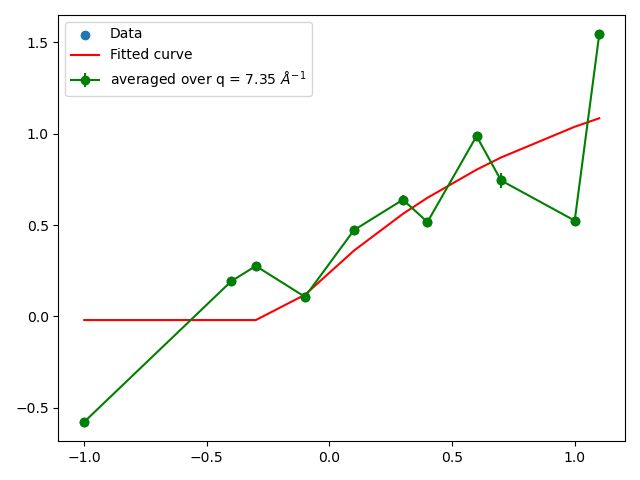

[ 1.60627734e+00  1.68267808e+02  1.02241034e+00 -2.13907968e-02]
[-0.01958513 -1.59330593  1.10133514 -0.2       ]
37.925000000000004


In [28]:
bounds = ([-0.5, -6, 0.1, -0.2], [0.5, 6, 20, 0.2])
fit, popt, error = expo_fitting(Time_real, inten_avg_2, bounds=bounds, func=t0_finder)

# Generate points for the fitted curve
# x_fit = np.linspace(-2, 2, 100)
y_fit = error_function(Time_real, *params)

# Plot the original data and the fitted curve
plt.figure()
plt.errorbar(Time_real, inten_avg_2, inten_std_2, color='g', fmt='-o', label=r'averaged over q = %1.2f $\AA^{-1}$'%s3)
plt.scatter(Time_real, inten_avg_2, label='Data')
#plt.plot(Time_real, y_fit, label='Fitted curve', color='r')
plt.plot(Time_real, fit, label='Fitted curve', color='r')             
plt.legend()

plt.tight_layout()
plt.show()

print(params)
print(popt)
print(T0-(popt[3]*0.15))# ps

In [53]:
inten_avg_3

array([-4.20575707, -3.84673114, -4.25586234, -3.80689799, -3.70651873,
       -3.320837  , -3.31738533, -2.75817826, -3.20992754, -3.26239646,
       -2.45200341, -2.62642739, -2.46162854, -2.7994432 , -2.23458146,
       -1.12728356, -0.57508033,  0.22180964, -0.05172625, -0.14366452,
       -0.02641887])

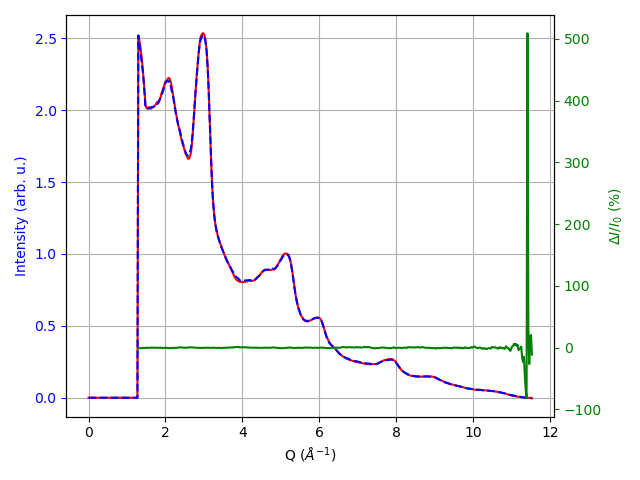

In [29]:
fig, ax1 = plt.subplots()
ax1.plot(s, rad_pro_avg[:,-1], 'r-',label='Before t0')
ax1.plot(s, rad_pro_avg[:,1], 'b--', label='After t0')
ax1.set_xlabel('time (s)')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Intensity (arb. u.)', color='b')
ax1.tick_params('y', colors='b')
ax1.grid()

ax2 = ax1.twinx()
ax2.plot(s, rad_pro_avg_diff[:,1], 'g-', label=r'$\Delta I/I_0$')
ax2.set_ylabel(r'$\Delta I/I_0$ (%)', color='g')
ax2.tick_params('y', colors='g')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
# ax1.legend(h1+h2, l1+l2, loc='best', fram240240eon=False)
ax1.set_xlabel(r'Q ($\AA^{-1}$)')
fig.tight_layout()

In [ ]:
# Define the error function
def error_function(x, a, b, c, d):
    return a * np.exp(-b * (x - c) ** 2) + d

# Generate sample data
x_data = np.linspace(-2, 2, 100)
y_data = 3 * np.exp(-2 * x_data ** 2) + 0.5

# Add some noise to the data
np.random.seed(0)
y_data += 0.2 * np.random.normal(size=len(x_data))

# Fit the data to the error function
params, covariance = curve_fit(error_function, Time_real, y_data)

# Generate points for the fitted curve
x_fit = np.linspace(-2, 2, 100)
y_fit = error_function(x_fit, *params)

# Plot the original data and the fitted curve
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_fit, y_fit, label='Fitted curve', color='r')
plt.legend()
plt.show()